In [1]:
import os, glob, time, datetime
import numpy as np
import imageio
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
from torchvision.utils import save_image

from common.dataset import TrainDataProvider
from common.function import init_embedding, interpolated_embedding_lookup
from common.models import Encoder, Decoder, Discriminator, Generator
from common.utils import denorm_image, centering_image, save_gif, chars_to_ids
from common.train import interpolation
from get_data.package import pickle_interpolation_data, pickle_examples

### GPU Option

In [2]:
GPU = torch.cuda.is_available()
GPU

True

### Hyperparameter setting

In [12]:
FONTS_NUM = 25
EMBEDDING_NUM = 100
BATCH_SIZE = 5
IMG_SIZE = 128
EMBEDDING_DIM = 128

from_model_path = './model_checkpoint/'
data_dir = './interpolation/dataset/'
fixed_dir = './fixed_sample/'

### 150epoch trained model

In [4]:
En = Encoder().cuda()
De = Decoder().cuda()
D = Discriminator(category_num=FONTS_NUM).cuda()

In [5]:
restore = ['150-0604-10:42-Encoder.pkl', '150-0604-10:42-Decoder.pkl', '150-0604-10:42-Discriminator.pkl']

encoder_path, decoder_path, discriminator_path = restore
prev_epoch = int(encoder_path.split('-')[0])
En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
print("%d epoch trained model has restored" % prev_epoch)

150 epoch trained model has restored


### Embeddings

In [6]:
embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
embeddings.shape

torch.Size([100, 1, 1, 128])

In [7]:
font_filter = [14, 5, 11, 7, 0, 6, 8, 16, 19, 20, 15, 17, 10]
font_filter_plus = font_filter + [font_filter[0]]
interpolated_font_ids = [(i, font_filter_plus[font_filter.index(i)+1]) for i in font_filter]
print(len(interpolated_font_ids))

13


### 원하는 문장 만들기
- 문장을 charid로 변환

In [8]:
sentence = '안녕하세요'
fixed_char_ids = chars_to_ids(sentence)
fixed_char_ids

[6472, 1365, 10584, 5432, 6804]

### charid와 함께 있는 모든 dataset 저장

In [9]:
# from_dir = './get_data/hangul-dataset-11172/'
# save_dir = './interpolation/dataset/'
# train_path = os.path.join(save_dir, "train_with_charid.obj")
# val_path = os.path.join(save_dir, "val_with_charid.obj")

# pickle_examples(from_dir, train_path=train_path, val_path=val_path, with_charid=True, train_val_split=0)

In [13]:
data_dir = './interpolation/dataset/'
train_name='train_with_charid.obj'
val_name='val_with_charid.obj'

data_provider = TrainDataProvider(data_dir, train_name=train_name, val_name=val_name, \
                                  filter_by_charid=fixed_char_ids, filter_by_font=font_filter, val=False)
total_batches = data_provider.compute_total_batch_num(BATCH_SIZE)
print("total batches:", total_batches)

unpickled total 226659 examples
filter by label -> [14, 5, 11, 7, 0, 6, 8, 16, 19, 20, 15, 17, 10]
filter by char -> [6472, 1365, 10584, 5432, 6804]
train examples -> 65
total batches: 13


---

### Grid: interpolation step

In [14]:
grids = [0., 0.5, 0.6, 0.7, 0.8]
print(len(grids))

5


여러번의 시행착오를 거쳐 확 변하는 구간을 찾아서 그 부분을 많이 늘린다.

## Image Centering
- 저장한 image들이 각각 다른 source로 생성되어서, center가 다 안맞는다.

- centering을 따로 해줄 필요

### interpolation 함수를 보완한다. 
- `real_source` 를 Encoder에 넣기 전에 cleansing (centering, size_fitting) 진행

### image 전부 저장하기

In [15]:
save_path = './interpolation/images_custom_sentence/'
grid_results = interpolation(data_provider, grids, fixed_char_ids, interpolated_font_ids, \
                             embeddings, En, De, batch_size=BATCH_SIZE, save_path=save_path, \
                             img_size=128, save_nrow=5, GPU=True)

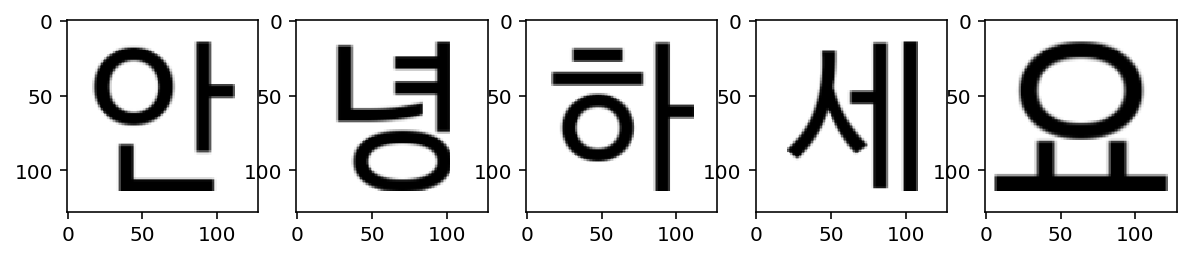

In [16]:
fontid = interpolated_font_ids[0]

plt.figure(figsize=(12, 9))
idx = 1
fake_images = np.array([grid_results[fontid][charid][0] for charid in fixed_char_ids])
for image in fake_images:
    plt.subplot(4, 6, idx)
    plt.imshow(image.cpu().detach().numpy().reshape(128, 128), cmap='gray')
    idx += 1
plt.show()

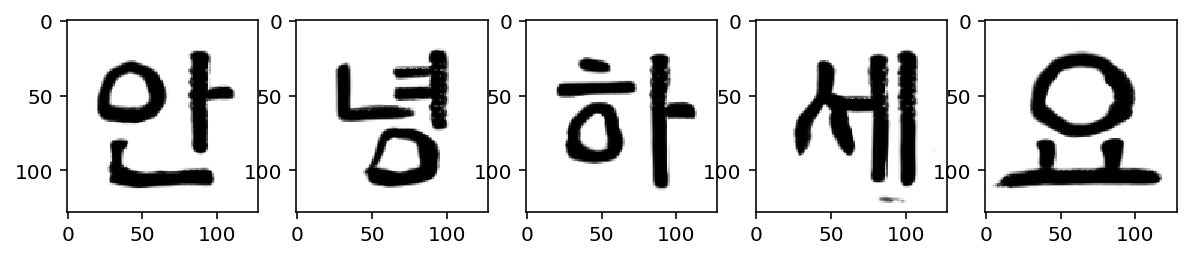

In [17]:
fontid = interpolated_font_ids[0]

plt.figure(figsize=(12, 9))
idx = 1
fake_images = np.array([grid_results[fontid][charid][2] for charid in fixed_char_ids])
for fontid, image in enumerate(fake_images):
    plt.subplot(4, 6, idx)
    plt.imshow(image.cpu().detach().numpy().reshape(128, 128), cmap='gray')
    idx += 1
plt.show()

- 이미지들이 중앙에 이쁘게 배열되고, 크기도 일정!!

### Load images

In [18]:
image_path = './interpolation/images_custom_sentence/'
filenames = sorted(glob.glob(os.path.join(image_path, "*.png")))
len(filenames)

65

- 총 180개의 이미지

## GIF file 생성

In [19]:
gif_path = './interpolation/gifz'
image_path = './interpolation/images_custom_sentence'
file_name = 'images_custom_sentence.gif'

save_gif(gif_path, image_path, file_name)